In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Import thư viện cần thiết

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_absolute_error


# 2. Đọc file csv và gắng index với giá Close

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_Analyst/Datasets/INTC Historical Data.csv')
df1=df.reset_index()['Price']
len(df)

1624

# 3.Scaler data

In [4]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test

In [5]:
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
print(train_size, test_size, val_size)

974 487 163


# 5.Hàm Create Dataset

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
# import numpy
# # convert an array of values into a dataset matrix
# def create_dataset(dataset, time_step=1):
# 	dataX, dataY = [], []
# 	for i in range(len(dataset)-time_step-1):
# 		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
# 		dataX.append(a)
# 		dataY.append(dataset[i + time_step, 0])
# 	return numpy.array(dataX), numpy.array(dataY)

#6.Reshape into X=t,t+1,t+2..t+99 and Y=t+100

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X, y = create_dataset(df1, time_step)

X_train = X[:train_size-100]
X_test = X[train_size-100:train_size-100+test_size]
X_val = X[train_size-100+test_size:]

y_train = y[:train_size-100]
ytest = y[train_size-100:train_size-100+test_size]
yval = y[train_size+test_size-100:]

In [10]:
# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_val, yval = create_dataset(val_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM

In [11]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

# 8. Define GRU Model

In [12]:
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train

In [13]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 5s 127ms/step - loss: 0.1551 - val_loss: 0.0097
Epoch 2/100
14/14 [==============================] - 1s 85ms/step - loss: 0.0178 - val_loss: 0.0084
Epoch 3/100
14/14 [==============================] - 2s 176ms/step - loss: 0.0066 - val_loss: 0.0094
Epoch 4/100
14/14 [==============================] - 1s 92ms/step - loss: 0.0049 - val_loss: 0.0071
Epoch 5/100
14/14 [==============================] - 1s 78ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 6/100
14/14 [==============================] - 1s 89ms/step - loss: 0.0034 - val_loss: 0.0050
Epoch 7/100
14/14 [==============================] - 1s 84ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 8/100
14/14 [==============================] - 1s 78ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 9/100
14/14 [==============================] - 1s 105ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 10/100
14/14 [==============================] - 1s 47ms/step - loss: 0.0019 - val_loss: 0.0

# 10.Dự báo dữ liệu test, val

In [14]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 13ms/step


# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val


In [15]:
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAE

In [16]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)

Validation RMSE: 29.322252668656418
Validation MAE: 29.262804525320394
Testing RMSE: 49.655306949760146
Testing MAE: 48.80153200632698


# 13. Dự báo 30 ngày tiếp theo

In [17]:
# 13. Dự báo 30 ngày tiếp theo
n_steps=time_step
x_input=val_data[-n_steps:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]

i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.24848045]
101
1 day input [0.11016755 0.11911866 0.07482213 0.0700023  0.07711728 0.09570806
 0.12141382 0.12439752 0.08698646 0.09524902 0.07665825 0.06495295
 0.06655956 0.08377324 0.08583888 0.09065871 0.07574019 0.06219876
 0.02662382 0.0130824  0.01629562 0.00550838 0.         0.00068855
 0.00986918 0.02983704 0.03442736 0.02501721 0.01445949 0.0247877
 0.03534542 0.05324765 0.04705072 0.07137939 0.08056002 0.1211843
 0.11269222 0.0977737  0.0817076  0.07413358 0.09478999 0.10236401
 0.09823273 0.1007574  0.15193941 0.1650218  0.17833372 0.18338306
 0.18820289 0.18200597 0.18154694 0.17489098 0.17098921 0.16341519
 0.16593987 0.16043149 0.16616938 0.1590544  0.14344733 0.13679137
 0.12393849 0.10924948 0.09134726 0.09524902 0.1138398  0.14138168
 0.12393849 0.11177416 0.13197154 0.14551297 0.13977507 0.13472573
 0.11934818 0.11636447 0.09088823 0.09295387 0.1124627  0.09915079
 0.09111774 0.10970852 0.11544641 0.12347946 0.10580675 0.09410145
 0.05737893 0.09410145 0.1168235  0

In [18]:
# x_input=val_data[60:].reshape(1,-1)
# x_input.shape

# temp_input=list(x_input)
# temp_input=temp_input[0].tolist()

# from numpy import array

# lst_output=[]
# n_steps = 103
# i=0
# while(i<30):

#     if(len(temp_input)>100):
#         #print(temp_input)
#         x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
#         x_input=x_input.reshape(1,-1)
#         x_input = x_input.reshape((1, n_steps, 1))
#         #print(x_input)
#         yhat = model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
#         temp_input.extend(yhat[0].tolist())
#         temp_input=temp_input[1:]
#         #print(temp_input)
#         lst_output.extend(yhat.tolist())
#         i=i+1
#     else:
#         x_input = x_input.reshape((1, n_steps,1))
#         yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
#         temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
#         lst_output.extend(yhat.tolist())
#         i=i+1


In [19]:
x_input.shape

(1, 100, 1)

# 14.Vẽ hình

Validation RMSE: 29.322252668656418
Validation MAE: 29.262804525320394
Testing RMSE: 49.655306949760146
Testing MAE: 48.80153200632698


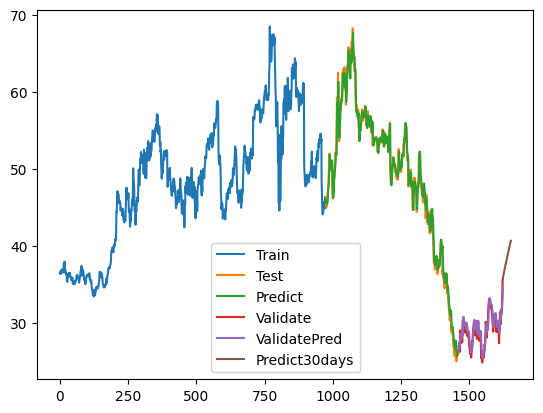

In [20]:
# 14.Vẽ hình
print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()
# print(lst_output)

In [21]:
# train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
# plt.plot(scaler.inverse_transform(train_data))
# test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
# plt.plot(test_data_index,scaler.inverse_transform(test_data))
# test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
# plt.plot(test_data_index,(y_pred))
# val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
# plt.plot(val_data_index,scaler.inverse_transform(val_data))
# val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
# plt.plot(val_data_index,y_pred_val)
# prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
# plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
# plt.show()

# 15.Vẽ hình Predict 30 days


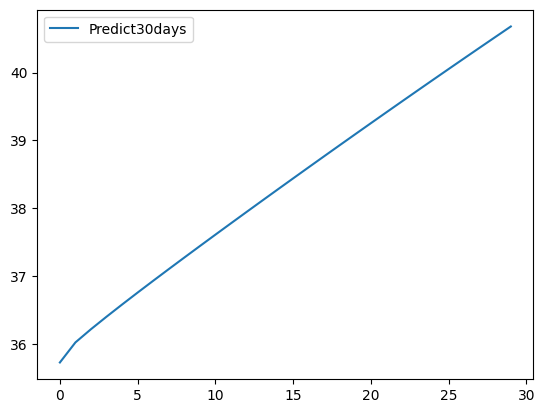

In [22]:
prediect_data_index = pd.RangeIndex(start=0, stop=30, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Predict30days'])
plt.show()

In [23]:
scaler.inverse_transform(lst_output)[:30, 0]


array([35.72629338, 36.02229458, 36.21707674, 36.40118275, 36.58065445,
       36.75676048, 36.93044353, 37.1023061 , 37.27273124, 37.44198126,
       37.61024182, 37.77763111, 37.94424   , 38.11013472, 38.27535423,
       38.43993099, 38.60388447, 38.76722118, 38.92995019, 39.0920793 ,
       39.25360461, 39.41451964, 39.57482956, 39.73452791, 39.89360687,
       40.05206256, 40.20988719, 40.36706906, 40.52360429, 40.67948767])